<a href="https://colab.research.google.com/github/Vitamin99CC/23WS_DeepLearning_FAU/blob/main/exercise-11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert-block alert-info alert"> Hello! If this is your first assignment please read the following instructions:

Read the questions carefully and code what is asked in the respective code block whenever you see a ``` #TODO: YOUR CODE HERE. ```
It is important to do the Coding tasks IN ORDER, as the majority of coding blocks are dependent on the
previous coding blocks in the notebook.
Please also note that there is a **raise NotImplementedError()** for each task or function you have to
implement, so don't forget to remove it before testing your code, otherwise you will always get a "not
implemented" error.

You need to manually upload the data used in this exercise to Colab. Just create a folder 'data' and paste the respective files into this folder. Otherwise, you will get a 'File not found' error. You can find the data in StudOn.

Aside from coding blocks, there are also testing blocks to check whether your implementations
are correct, you can run them but do not change the code inside of them.
The tests are determined via the ASSERT STATEMENTS that you see on the testing blocks, which can help you
out during the coding of the exercises. If you pass all the visible asserts, you will probably get a good
grade on the exercise, just remember that there are also hidden tests, so hardcoding the assert statements
won't help you.

REMEMBER: This Colab notebook DOES NOT HAVE AN AUTOSAVE FUNCTION, so whenever you want to close it, please
remember to save it by clicking on the "file" tab in the upper left corner of the page, followed by
clicking on the "Save a copy to GitHub" button and selecting your corresponding GitHub repository:
"madlab-biosig/exercise-x-YourGitHubUsername"

Before you save the final version of your assignment, please make sure everything runs as expected.
First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all
cells** (in the menubar, select Cell$\rightarrow$Run All).
</div>

Test commit

### BioSig Exercises WS 23/24
---

# Exercise 11

In [ ]:
try:
    %matplotlib widget
    print('Using widgets')
except:
    try:
        print('Using Notebook widgets')
        %matplotlib notebook
    except:
        print('Using static backend')
        %matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 40})
import pandas as pd
import numpy as np
import scipy
import scipy.signal

Using Notebook widgets
Using static backend


## Ex 11.1: Extraction of Q-, R-, and S-peaks

To perform waveform analysis on individual heartbeats in an ECG signal, we need to find all relevant peaks within each repetition of the signal.

a) Load the example ecg file (`103.csv`) from the data folder using pandas. The signal is sampled at 360 Hz. Optionally apply a band-pass filter to see its effect.

b) Load the file `103_all.csv`. It contains the position of all R-peaks in the signal.

c) Extract all QRST complexes from the signal by considering a region spanning from 50 ms before until 250 ms after the R-peak.

d) Create a function to find the Q-peak by looking for a minimum left of the R-peaks within a reasonable interval.

e) Create a function to find the S-peak by looking for a minimum right of the R-peaks within a reasonable interval.

f) Add the position of the Q- and the S-peak as new columns to the DataFrame loaded in step b)


In [ ]:
# Load the data and store it in a pd.Series called signal.
# Ensure that the index is in seconds
SUBJECT = 103
sampling_rate = 360  # hz

# YOUR CODE HERE
signal = pd.read_csv("./data/" + str(SUBJECT) + ".csv", index_col=0)
signal.index /= sampling_rate
signal = signal.squeeze()

# Optionally apply a bandpass filter to the signal (3-50 Hz passband)
# Test all computations in this exercise  with and without the filter
# Store the filter coefficients as 'b' and 'a'
# YOUR CODE HERE

order = 5
freq = [3, 50]
b, a = scipy.signal.butter(order, freq, btype="bandpass", fs=sampling_rate)
sig = scipy.signal.filtfilt(b, a, signal)
signal = pd.Series(sig, index=signal.index, name=signal.name)


In [ ]:
# Load the labeled R-peaks an store them in pd.DataFrame called `peaks`
# YOUR CODE HERE
peaks = pd.read_csv("./data/" + str(SUBJECT) + "_all.csv", index_col=0)

In [ ]:
assert peaks.iloc[0, 0] == 265, 'The first R peak is found wrong.'
print('The first R peak is found correct.')

The first R peak is found correct.


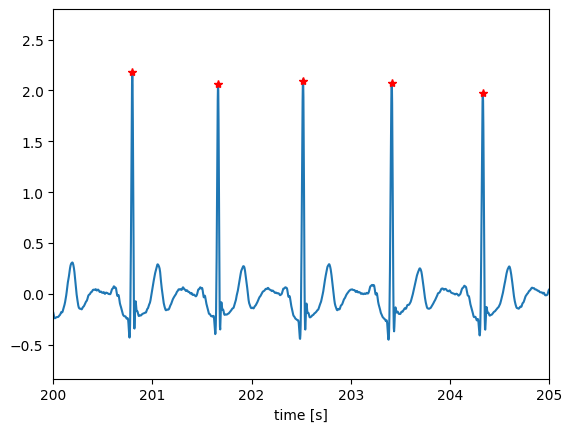

In [ ]:
plt.figure()
signal.plot()

# r peaks
pos = peaks['R']/sampling_rate
plt.plot(pos, signal.loc[pos], 'r*')

plt.xlabel('time [s]')
plt.xlim(200, 205);

In [ ]:
def extract_qrst_complexes(signal, r_peaks, sampling_rate=360):
    """Extract all qrst complexes from a continous signal.

    Cuts out a region of -50ms to 250ms around each provided R-peak

    Args:
        signal: np.array of ecg signal
        r_peaks: list of indices indicating the postion of R-peaks in the signal
        sampling_rate: Ssampling rate of the recording

    Returns:
        qrst: np.array with fixed number of culumns and one qrst complex per row
    """
    signal = np.array(signal)
    # YOUR CODE HERE
    start = r_peaks - 0.05 * sampling_rate
    end = r_peaks + 0.25 * sampling_rate
    qrst = np.array([signal[int(s):int(e)] for s, e in zip(start, end)])
    return qrst

In [ ]:
qrst_complexes = extract_qrst_complexes(signal, r_peaks=peaks['R'])

In [ ]:
assert abs(sum(sum(qrst_complexes[0:1040][0:1400])) - 2836.8060839440473) < 1e-3, 'The half of the extracted qrst complexes are wrong'
print('The half of the extracted qrst complexes are correct.')

The half of the extracted qrst complexes are correct.


In [ ]:
def find_q_peak(qrst, sampling_rate=360):
    """Find the Q peak in an array of qrst complexes extracted before.

    The Q peak is the first valley to the left of the R-Peak

    Returns:
        The relative distance from the R-Peak in samples
    """
    # YOUR CODE HERE
    index_q = []
    index_r = int(0.05 * sampling_rate)
    for row in qrst:
      q, _ = scipy.signal.find_peaks(row[0:index_r]*-1, distance=1000)
      index_q.append(q[0])
    index_q = index_r - np.array(index_q)
    return index_q

def find_s_peak(qrst, sampling_rate=360):
    """Find the S peak in an array of qrst complexes extracted before.

    The S peak is the first valley to the right of the R-Peak

    Returns:
        The relative distance from the R-Peak in samples
    """
    # YOUR CODE HERE
    index_s = []
    index_r = int(0.05 * sampling_rate)
    for row in qrst:
      s, _ = scipy.signal.find_peaks(row[index_r:]*-1, distance=1000)
      index_s.append(s[0])
    index_s = np.array(index_s)
    return index_s

In [ ]:
peaks['Q'] = peaks['R'] - find_q_peak(qrst_complexes)
peaks['S'] = peaks['R'] + find_s_peak(qrst_complexes)
peaks.head(5)

,R,Q,S
0,265,254,273
1,575,565,583
2,876,866,884
3,1180,1170,1188
4,1482,1472,1490


In [ ]:
assert peaks['Q'][0] == 254, 'The first Q peak is found wrong.'
assert peaks['S'][0] == 273, 'The first S peak is found wrong.'
print('The first Q and S peaks are found correct.')


The first Q and S peaks are found correct.


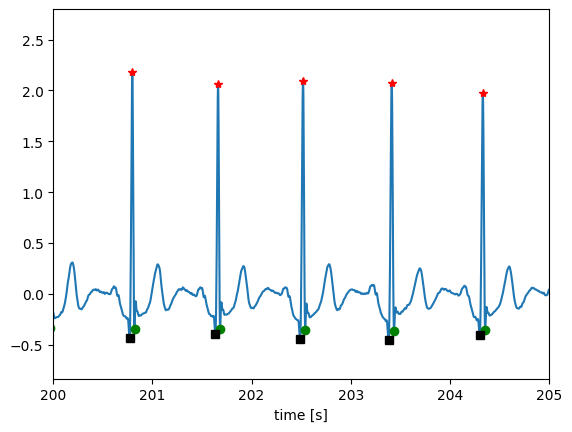

In [ ]:
plt.figure()
plt.plot(signal)

peak_pos = peaks[['Q', 'R', 'S']] / sampling_rate
plt.plot(peak_pos['R'], signal.loc[peak_pos['R']], 'r*')
plt.plot(peak_pos['S'], signal.loc[peak_pos['S']], 'go')
plt.plot(peak_pos['Q'], signal.loc[peak_pos['Q']], 'ks')

plt.xlabel('time [s]')
plt.xlim(200, 205);

## Ex. 11.2: ECG feature

To describe each extracted QRST complexes we can calculate a set of features on each complex.
These features can later be used in a ML classification.

a) Implement the following features and add each of them as a new column to the `peaks` array:

1. Compute the QRS widths as the difference between the S-peaks and the Q-peaks

2. Compute the amplitude of the QR difference

3. Compute the amplitude of the RS difference

4. Compute the area below the QRST curve as follows:

- Subtract the mean of each QRST complex from each complex.
- take the absolut of all values
- Compute the area of the resulting curve by summing up all the elements.

5. Compute the normalized scalar product of a QRS complex and the template of a normal QRS complex with the following formula:
$$
c=\frac{\sum_{n = 1}^{N} [x(n) - min(x)] [y (n) - min(y)]}{\sqrt{\sum_{n=1}^{N}[x(n) - min(x)]^2 \sum_{n=1}^{N}[y(n) - min(y)]^2 }}
$$
$x(n) = $ template (first QRS complex of the ECG signal),
$y(n) = $ the QRS complex of interest,
$N = $ amount of samples the heartbeat contains,

b) Plot the results of all features and visually inspect potential outliers.

In [ ]:
# Implement the following feature and add each of them as a new column to the `peaks` array

# QRS-width
# Calculate the distance between the S- and the Q-"valley" in seconds. The column should be named as 'QRS_Width'
# YOUR CODE HERE
peaks['QRS_Width'] = (peaks['S'] - peaks['Q']) / sampling_rate

# QR Amplitude difference
# Calculate the amplitude difference between the R-peak and the Q-valey. The column should be named as 'QR_amplitude'
# YOUR CODE HERE
peaks['QR_amplitude'] = signal.values[peaks['R'].values] - signal.values[peaks['Q'].values]

# RS Amplitude difference
# Calculate the amplitude difference between the R-peak and the S-valey. The column should be named as 'RS_amplitude'
### BEGIN SOLTUION
peaks['RS_amplitude'] = signal.values[peaks['R'].values] - signal.values[peaks['S'].values]

# QRST Area
# Calculate the area under each QRST complex after substracting the mean value of each complex to
# normalize the baseline. The column should be named as 'QRST_area'
# YOUR CODE HERE
#peaks["QRST_area"] = np.array([np.trapz(row - np.mean(row), (np.arange(0, row.shape[0])*1./360)) for row in qrst_complexes])
peaks["QRST_area"] = np.array([np.sum(np.abs(row - np.mean(row))) for row in qrst_complexes])
# Template Match
# We assume the first peak in the series is a normal QRST complex
# Substract the baseline (minimum) from every qrst complex and then calculate the normalised dot-product (a*b/(|a||b|))
# YOUR CODE HERE
peaks["Template"] = np.array([np.dot(row - np.min(row), qrst_complexes[0] - np.min(qrst_complexes[0])) / (np.linalg.norm(row - np.min(row)) * np.linalg.norm(qrst_complexes[0] - np.min(qrst_complexes[0]))) for row in qrst_complexes])

In [ ]:
assert abs(sum(peaks['QRS_Width'][0:1040]) - 53.91388888888858) < 1e-3, 'Half of the samples for the QRS_Width are wrong'
assert abs(sum(peaks['QR_amplitude'][0:1040]) - 2496.889959835294) < 1e-3, 'Half of the samples for the QR_amplitude are wrong'
assert abs(sum(peaks['RS_amplitude'][0:1040]) - 2483.7101152334803) < 1e-3, 'Half of the samples for the RS_amplitude are wrong'
assert abs(sum(peaks['QRST_area'][0:1040]) - 32009.79782801534) < 1e-3, 'Half of the samples for the QRST_area are wrong'


fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(9, 5))

for ax, feature in zip(axs.flatten(), ['QRS_Width', 'QR_amplitude', 'RS_amplitude', 'QRST_area', 'Template']):
    ax.plot(peaks['R']/sampling_rate, peaks[feature])
    ax.set_title(feature)

axs[1, 1].set_xlabel('time [s]')
plt.tight_layout()
axs[1, -1].remove()

## Ex. 11.3: Critical analysis of the pipeline

a) Look through the results and the plotted ECG signal. What are potential issues that could have effected our feature calculation?

b) How could we solve these issues?